In [51]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import clear_border
from skimage import io, measure
from skimage.measure import label,regionprops
from scipy import ndimage as ndi
from scipy.ndimage import measurements, center_of_mass, binary_dilation, zoom
import plotly.graph_objects as go
import cv2
import pyrealsense2 as rs
from copy import deepcopy
import colorsys

## File paths

In [736]:
# filepath = r'./images/img0.png'
filepath = r'./images/20.png'
# filepath = r'./images/img1.png'
# filepath = r'./images/1_a.jpg'
# filepath = r'./images/1_b.png' # -> error when the cable appears!
# filepath = r'./images/2_b.png'

In [737]:
# Do you want plots and verbose printing?
verbose = True

## Load file

(480, 640, 3)


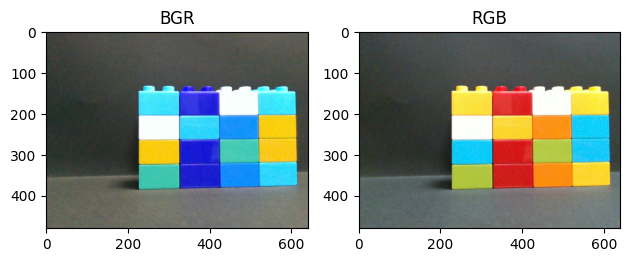

In [738]:
img_BGR = cv2.imread(filepath) # cv2 gives you the BGR color space, but skimage because it load the .jpg wiht RGB colors
img_RGB = io.imread(filepath)
print(img_RGB.shape)
if True:
    plt.subplot(1, 2, 1)
    plt.imshow(img_BGR)
    plt.title('BGR')
    plt.subplot(1, 2, 2)
    plt.imshow(img_RGB)
    plt.title('RGB')
    plt.tight_layout()
    plt.show()
    img = img_RGB

## Edges detection and box drawings

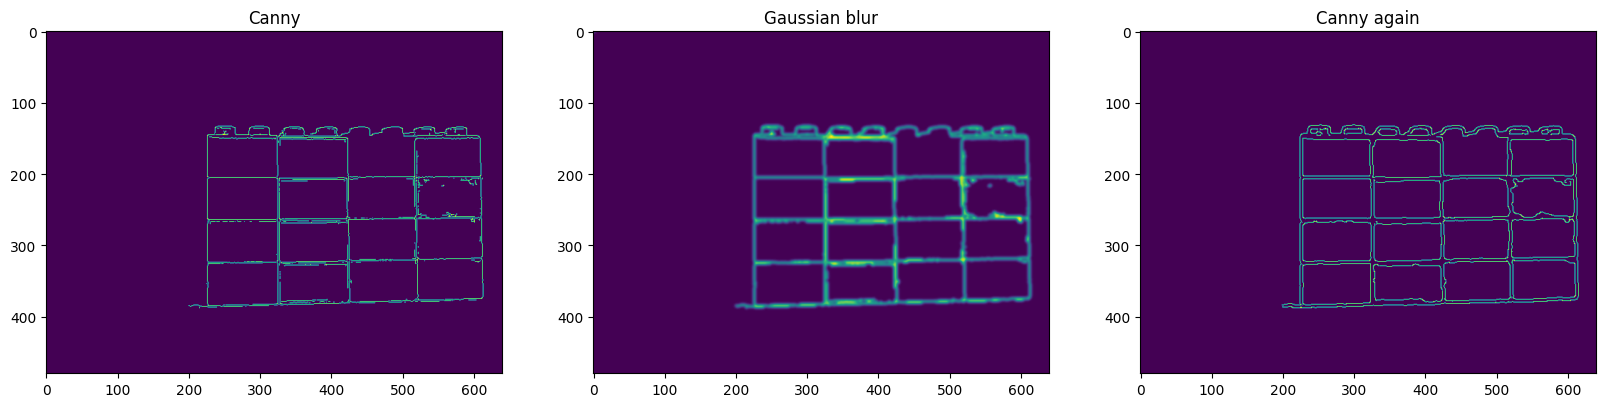

In [739]:
##################### Canny to obtain edges #####################
edges_r = cv2.Canny(img, 100, 250)
if verbose:
    plt.figure(figsize=(20, 8)) 
    plt.subplot(1, 3, 1)
    plt.imshow(edges_r)
    plt.title('Canny')
blurred = cv2.GaussianBlur(edges_r, (17, 17), 2)
if verbose:
    plt.subplot(1, 3, 2)
    plt.imshow(blurred)
    plt.title('Gaussian blur')
edges_r = cv2.Canny(blurred, 90, 150)
if verbose:
    plt.subplot(1, 3, 3)
    plt.title('Canny again')
    plt.imshow(edges_r)

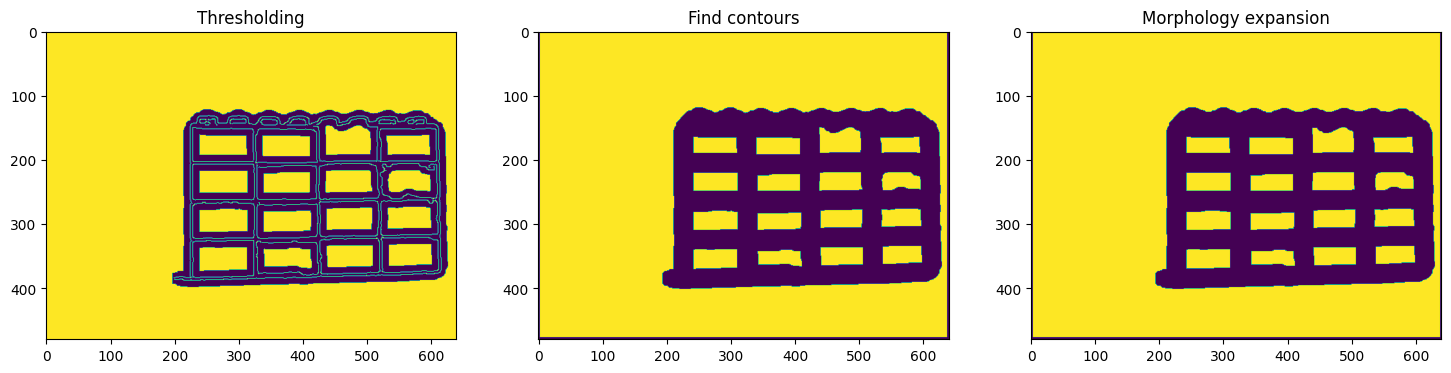

In [740]:
##################### We increase the edges to obtain better boxes #####################
thresh = cv2.adaptiveThreshold(edges_r, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 10)
if verbose:
    plt.figure(figsize=(18, 6)) 
    plt.subplot(1, 3, 1)
    plt.imshow(thresh)
    plt.title('Thresholding')
thresh_cpy = thresh.copy()
cnts = cv2.findContours(thresh_cpy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    cv2.drawContours(thresh_cpy, [c], -1, (0,0,0), 4)
if verbose:
    plt.subplot(1, 3, 2)
    plt.imshow(thresh_cpy)
    plt.title('Find contours')
# Morph open
thresh_cpy_2 = thresh_cpy.copy()
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opening = cv2.morphologyEx(thresh_cpy_2, cv2.MORPH_OPEN, kernel, iterations=1)
if verbose:
    plt.subplot(1, 3, 3)
    plt.imshow(opening)
    plt.title('Morphology expansion')

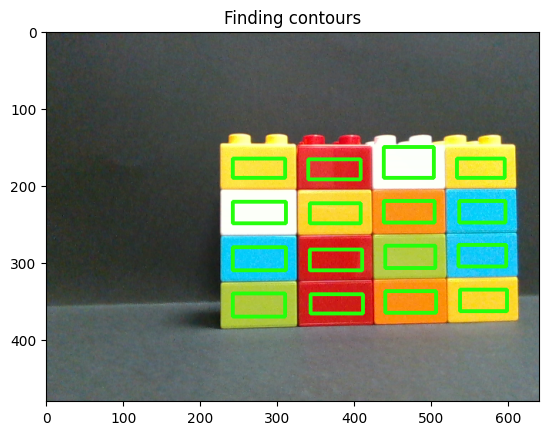

In [741]:
##################### Draw rectangles #####################
## the 'area_treshold' value was determined empirically
opening_cpy = opening.copy()
image_cpy = img.copy()
cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
area_treshold = 10000
area_min = 800
legos = []
for c in cnts:
    area = cv2.contourArea(c)
    if area > area_min and area < area_treshold :
      x,y,w,h = cv2.boundingRect(c)
      legos.append([x, y, w, h])
      cv2.rectangle(image_cpy, (x, y), (x + w, y + h), (36,255,12), 3)
plt.imshow(image_cpy)
plt.title('Finding contours')
plt.show()

## Position boxes filtering

In [709]:
verbose = True

In [720]:
# Primero arreglamos las x's
xlegos = legos.copy()
xlegos.sort(key=lambda x: x[0])
if verbose:
    print(legos)
    print(20*"-")
    print(xlegos)
# here we will save a list of lists. 
# Each list will consist of similar x position.
legos_x = [] 
if verbose:
    print(60*"-","INIT",60*"-")
while (len(xlegos)>0):
    compare_x = []
    lego = xlegos.pop(0)
    compare_x.append(lego)
    x_ref, _, _, _ = lego
    if verbose:
        print(lego)
        print(compare_x)
        print(x_ref)
        print(10*"-")
    ilego = []
    for i in range(len(xlegos)):
        x, _, _, _ = xlegos[i]
        if verbose:
            print(x)
        if (abs(x - x_ref) <= 35):
            ilego.append(i)
            if verbose:
                print(ilego)
    if verbose:
        print(10*"-")
    for i in ilego:      
        lego = xlegos[i]
        compare_x.append(lego)
    legos_x.append(compare_x)
    xlegos = [xlegos[i] for i in range(len(xlegos)) if i not in ilego]
    if verbose:
        print(compare_x)
        print(60*"-")

[[192, 330, 58, 24], [457, 328, 56, 20], [371, 328, 55, 22], [282, 323, 58, 28], [282, 280, 57, 19], [192, 280, 59, 19], [370, 279, 56, 20], [457, 276, 55, 29]]
--------------------
[[192, 330, 58, 24], [192, 280, 59, 19], [282, 323, 58, 28], [282, 280, 57, 19], [370, 279, 56, 20], [371, 328, 55, 22], [457, 328, 56, 20], [457, 276, 55, 29]]
------------------------------------------------------------ INIT ------------------------------------------------------------
[192, 330, 58, 24]
[[192, 330, 58, 24]]
192
----------
192
[0]
282
282
370
371
457
457
----------
[[192, 330, 58, 24], [192, 280, 59, 19]]
------------------------------------------------------------
[282, 323, 58, 28]
[[282, 323, 58, 28]]
282
----------
282
[0]
370
371
457
457
----------
[[282, 323, 58, 28], [282, 280, 57, 19]]
------------------------------------------------------------
[370, 279, 56, 20]
[[370, 279, 56, 20]]
370
----------
371
[0]
457
457
----------
[[370, 279, 56, 20], [371, 328, 55, 22]]
---------------

In [721]:
legos_x

[[[192, 330, 58, 24], [192, 280, 59, 19]],
 [[282, 323, 58, 28], [282, 280, 57, 19]],
 [[370, 279, 56, 20], [371, 328, 55, 22]],
 [[457, 328, 56, 20], [457, 276, 55, 29]]]

In [722]:
for i in range(len(legos_x)):
    sum = []
    for j in range(len(legos_x[i])):
        x, _, _, _ = legos_x[i][j]
        sum.append(x)
    the_mean = np.mean(sum)
    for j in range(len(legos_x[i])):
        legos_x[i][j][0] = round(the_mean)
# print(legos_x)
lego_columns = len(legos_x)

In [723]:
legos_x

[[[192, 330, 58, 24], [192, 280, 59, 19]],
 [[282, 323, 58, 28], [282, 280, 57, 19]],
 [[370, 279, 56, 20], [370, 328, 55, 22]],
 [[457, 328, 56, 20], [457, 276, 55, 29]]]

In [724]:
xlegos = []
for i in range(len(legos_x)):
    for j in range(len(legos_x[i])):
        legos_x[i][j].append([i+1])
        xlegos.append(legos_x[i][j]) 

In [725]:
xlegos

[[192, 330, 58, 24, [1]],
 [192, 280, 59, 19, [1]],
 [282, 323, 58, 28, [2]],
 [282, 280, 57, 19, [2]],
 [370, 279, 56, 20, [3]],
 [370, 328, 55, 22, [3]],
 [457, 328, 56, 20, [4]],
 [457, 276, 55, 29, [4]]]

In [726]:
ylegos = xlegos.copy()
ylegos.sort(key=lambda x: x[1])
if verbose:
    print(xlegos)
    print(20*"-")
    print(ylegos)
legos_y = []
if verbose:
    print(60*"-","INIT",60*"-")
while (len(ylegos)>0):
    compare_y = []
    lego = ylegos.pop(0)
    compare_y.append(lego)
    _, y_ref, _, _, _ = lego
    if verbose:
        print(lego)
        print(compare_y)
        print(y_ref)
        print(10*"-")
    ilego = []
    for i in range(len(ylegos)):
        _, y, _, _, _ = ylegos[i]
        if verbose:
            print(y)
        if (abs(y - y_ref) <= 20):
            ilego.append(i)
            if verbose:
                print(ilego)
    if verbose:
        print(10*"-")
    for i in ilego:      
        lego = ylegos[i]
        compare_y.append(lego)
    legos_y.append(compare_y)
    ylegos = [ylegos[i] for i in range(len(ylegos)) if i not in ilego]
    if verbose:
        print(compare_y)
        print(legos_y)
        print(60*"-")

[[192, 330, 58, 24, [1]], [192, 280, 59, 19, [1]], [282, 323, 58, 28, [2]], [282, 280, 57, 19, [2]], [370, 279, 56, 20, [3]], [370, 328, 55, 22, [3]], [457, 328, 56, 20, [4]], [457, 276, 55, 29, [4]]]
--------------------
[[457, 276, 55, 29, [4]], [370, 279, 56, 20, [3]], [192, 280, 59, 19, [1]], [282, 280, 57, 19, [2]], [282, 323, 58, 28, [2]], [370, 328, 55, 22, [3]], [457, 328, 56, 20, [4]], [192, 330, 58, 24, [1]]]
------------------------------------------------------------ INIT ------------------------------------------------------------
[457, 276, 55, 29, [4]]
[[457, 276, 55, 29, [4]]]
276
----------
279
[0]
280
[0, 1]
280
[0, 1, 2]
323
328
328
330
----------
[[457, 276, 55, 29, [4]], [370, 279, 56, 20, [3]], [192, 280, 59, 19, [1]], [282, 280, 57, 19, [2]]]
[[[457, 276, 55, 29, [4]], [370, 279, 56, 20, [3]], [192, 280, 59, 19, [1]], [282, 280, 57, 19, [2]]]]
------------------------------------------------------------
[282, 323, 58, 28, [2]]
[[282, 323, 58, 28, [2]]]
323
------

In [727]:
for i in range(len(legos_y)):
    sum = []
    for j in range(len(legos_y[i])):
        _, y, _, _, _ = legos_y[i][j]
        sum.append(y)
    the_mean = np.mean(sum)
    for j in range(len(legos_y[i])):
        legos_y[i][j][1] = round(the_mean)
lego_rows = len(legos_y)

In [728]:
legos_y

[[[457, 279, 55, 29, [4]],
  [370, 279, 56, 20, [3]],
  [192, 279, 59, 19, [1]],
  [282, 279, 57, 19, [2]]],
 [[282, 327, 58, 28, [2]],
  [370, 327, 55, 22, [3]],
  [457, 327, 56, 20, [4]],
  [192, 327, 58, 24, [1]]]]

In [729]:
legos = []
for i in range(len(legos_y)):
    for j in range(len(legos_y[i])):
        legos_y[i][j][4].append(len(legos_y)-i)
        legos.append(legos_y[i][j]) 


In [730]:
legos

[[457, 279, 55, 29, [4, 2]],
 [370, 279, 56, 20, [3, 2]],
 [192, 279, 59, 19, [1, 2]],
 [282, 279, 57, 19, [2, 2]],
 [282, 327, 58, 28, [2, 1]],
 [370, 327, 55, 22, [3, 1]],
 [457, 327, 56, 20, [4, 1]],
 [192, 327, 58, 24, [1, 1]]]

In [731]:
colors = {
    'blue': {
        'rgb': [[13, 177, 200], [69, 187, 212],[39,175,200], [58, 188, 213], [78, 199, 234], [5, 157, 189], [37, 237, 253], [37, 229, 253], [45, 200, 237], [45, 192, 222], [56, 213, 253], [14, 215, 251], [18, 209, 250], [32, 205, 248], [24, 196, 234], [13, 197, 235], [2, 204, 251]],
        'hsv': [[193.3, 77.6, 98.04], [193.398, 58.19, 69.41]]},
    # 'light_blue': {
    #     'rgb': [191, 228, 231], 
    #     'hsv': [92, 44, 231]},
    'white': {
        'rgb': [[206, 209, 208], [218, 215, 210], [243, 237, 231], [245, 244, 250], [192, 198, 200], [252, 255, 250]],
        'hsv': [[65.4545, 4.3137, 100.0000],[37.5000, 3.6866, 85.0980]]},
    'red': {
        'rgb': [[191, 62, 59], [169, 26, 26], [244, 50, 43], [190, 38, 33], [180, 28, 17], [168, 38, 33], [209, 55, 49], [194, 45, 47], [241, 37, 24], [200, 22, 19], [217, 47, 27], [207, 34, 15], [224, 45, 44], [223, 28, 27], [212, 18, 14]],
        'hsv': [[2.0690, 84.2324, 94.5098], [1.7021, 85.4545, 64.7059]]},
    # 'light_red': {
    #     'rgb': [253, 132, 126], 
    #     'hsv': [1, 128, 253]},
    'orange': {
        'rgb': [[252, 129, 21], [246, 116, 16], [230, 112, 23], [254, 172, 21], [252, 123, 2], [254, 161, 8], [252, 142, 4], [252, 145, 20], [252, 148, 31]],
        'hsv': [[26.2722, 66.2745, 100.0000], [24.6729, 91.0638, 92.1569]]},
    'green': {
        'rgb': [[158, 181, 57], [152, 168, 48], [162, 184, 79], [205, 233, 78], [197, 224, 81], [190, 207, 66], [176, 191, 46], [187, 202, 60], [202, 216, 51], [189, 204, 44], [172, 200, 64], [169, 198, 59]],
        'hsv': [[63.8961, 38.6935, 78.0392], [69.8824, 68.0000, 49.0196]]},
    # 'light_green': {
    #     'rgb': [213, 232, 163], 
    #     'hsv': [38, 76, 232]},
    'yellow': {
        'rgb': [[251, 202, 73], [251, 191, 43], [252, 189, 59], [253,192,70], [250,187,32], [252, 201, 32], [254, 255, 83], [253, 244, 45], [252, 230, 55], [252, 215, 41], [252, 204, 17], [253, 212, 52], [252, 228, 66]],
        'hsv': [[39.5455, 70.4000, 98.0392], [45.0829, 79.7357, 89.0196]]},
    # 'light_yellow': {
    #     'rgb': [251, 230, 143], 
    #     'hsv': [24, 110, 251]}
}

251 53 42
red rgb (251, 53, 42) [234, 40, 33] [254, 60, 53] [[191, 62, 59], [169, 26, 26], [244, 50, 43], [190, 38, 33], [180, 28, 17], [168, 38, 33], [209, 55, 49], [194, 45, 47], [241, 37, 24], [200, 22, 19], [217, 47, 27], [207, 34, 15], [224, 45, 44], [223, 28, 27], [212, 18, 14]]
37 237 253
blue rgb (37, 237, 253) [27, 227, 243] [47, 247, 263] [[13, 177, 200], [69, 187, 212], [39, 175, 200], [58, 188, 213], [78, 199, 234], [5, 157, 189], [37, 237, 253], [37, 229, 253], [45, 200, 237], [45, 192, 222], [56, 213, 253], [14, 215, 251], [18, 209, 250], [32, 205, 248], [24, 196, 234], [13, 197, 235], [2, 204, 251]]
205 233 78
green rgb (205, 233, 78) [195, 223, 68] [215, 243, 88] [[158, 181, 57], [152, 168, 48], [162, 184, 79], [205, 233, 78], [197, 224, 81], [190, 207, 66], [176, 191, 46], [187, 202, 60], [202, 216, 51], [189, 204, 44], [172, 200, 64], [169, 198, 59]]
37 229 253
blue rgb (37, 229, 253) [27, 227, 243] [47, 247, 263] [[13, 177, 200], [69, 187, 212], [39, 175, 200], [58, 

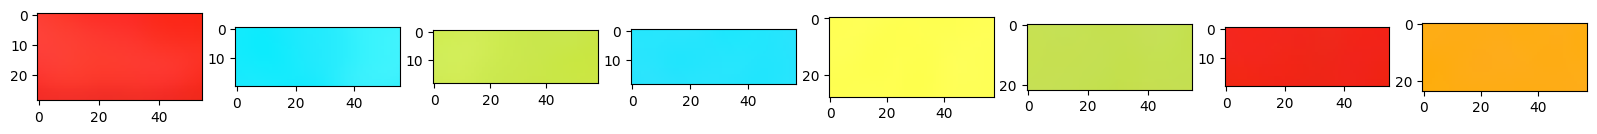

In [732]:
img_copy = img.copy()
img_copy = cv2.GaussianBlur(img_copy, (17, 17), 5)
m_legos = deepcopy(legos)
plt.figure(figsize=(20, 8)) 
for i in range(len((m_legos))):
    x, y, w, h, _ = m_legos[i]
    roi = img_copy[y:y+h, x:x+w]
    plt.subplot(1, len(m_legos), i+1)
    plt.imshow(roi)
    r = roi[:,:,0]
    g = roi[:,:,1]
    b = roi[:,:,2]
    r = round(np.mean(r))
    g = round(np.mean(g))
    b = round(np.mean(b))
    print(r,g,b)
    for key, value in colors.items():
        for space, value in value.items():
            if space == 'hsv':
                continue
            add = 10
            for in_value in value:
                plus = [x + add for x in in_value]
                minus = [x - add for x in in_value]
                if ( (r <= plus[0] and r >= minus[0]) and (g <= plus[1] and g >= minus[1]) and (b <= plus[2] and b >= minus[2]) ):
                    print(key, space, (r, g, b), minus, plus, value)
                    m_legos[i].append(in_value)
                    m_legos[i].append(key)
                    break
            

In [733]:
m_legos

[[457, 279, 55, 29, [4, 2], [244, 50, 43], 'red'],
 [370, 279, 56, 20, [3, 2], [37, 237, 253], 'blue'],
 [192, 279, 59, 19, [1, 2], [205, 233, 78], 'green'],
 [282, 279, 57, 19, [2, 2], [37, 237, 253], 'blue'],
 [282, 327, 58, 28, [2, 1], [254, 255, 83], 'yellow'],
 [370, 327, 55, 22, [3, 1], [205, 233, 78], 'green'],
 [457, 327, 56, 20, [4, 1], [241, 37, 24], 'red'],
 [192, 327, 58, 24, [1, 1], [254, 172, 21], 'orange']]

In [734]:
# Lets build!!!
my_legos = m_legos.copy()

for j in range(1,lego_rows+1):
    for i in range(1,lego_columns+1):
        # print(i,j)
        for my_lego in my_legos:
            if ( (my_lego[4][0] == i) and (my_lego[4][1] == j)):
                print(my_lego)

[192, 327, 58, 24, [1, 1], [254, 172, 21], 'orange']
[282, 327, 58, 28, [2, 1], [254, 255, 83], 'yellow']
[370, 327, 55, 22, [3, 1], [205, 233, 78], 'green']
[457, 327, 56, 20, [4, 1], [241, 37, 24], 'red']
[192, 279, 59, 19, [1, 2], [205, 233, 78], 'green']
[282, 279, 57, 19, [2, 2], [37, 237, 253], 'blue']
[370, 279, 56, 20, [3, 2], [37, 237, 253], 'blue']
[457, 279, 55, 29, [4, 2], [244, 50, 43], 'red']


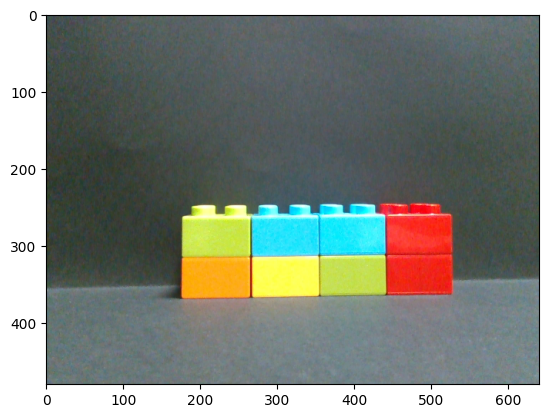

In [735]:
plt.imshow(img)

## Dynamic Test

In [164]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [50]:
if True:
    pipe = rs.pipeline()
    cfg  = rs.config()
    cfg.enable_stream(rs.stream.color, 640,480, rs.format.bgr8, 30)
    cfg.enable_stream(rs.stream.depth, 640,480, rs.format.z16, 30)
    pipe.start(cfg)
    once = True
    
    while True:
        frame = pipe.wait_for_frames()
        # depth_frame = frame.get_depth_frame()
        color_frame = frame.get_color_frame()
        # depth_image = np.asanyarray(depth_frame.get_data())
        color_image = np.asanyarray(color_frame.get_data())#,dtype=np.uint8)
        # color_image = increase_brightness(color_image,50)
        if once:
            # image = increase_brightness(color_image,50)
            # image = color_image
            # cv2.imwrite('images/' + str(12) + '.png', image)
            # print(color_image)
            once = False
        cv2.imshow('now', color_image)
        # depth_cm = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha = 0.5), cv2.COLORMAP_JET)
        # gray_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)
        img = color_image
        edges_r = cv2.Canny(img, 100, 200)
        blurred = cv2.GaussianBlur(edges_r, (17, 17), 2)
        edges_r = cv2.Canny(blurred, 90, 150)
        
        cv2.imshow('edges', edges_r)
        
        thresh = cv2.adaptiveThreshold(edges_r, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 21, 1)
        thresh_cpy = thresh.copy()
        cnts = cv2.findContours(thresh_cpy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(thresh_cpy, [c], -1, (0,0,0), 4)
        # Morph open
        thresh_cpy_2 = thresh_cpy.copy()
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        opening = cv2.morphologyEx(thresh_cpy_2, cv2.MORPH_OPEN, kernel, iterations=1)
        
        cv2.imshow('expansion', opening)
        
        image_cpy = img.copy()
        cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        area_treshold = 2000
        area_min = 900
        for c in cnts:
            area = cv2.contourArea(c)
            if area > area_min and area < area_treshold :
              x,y,w,h = cv2.boundingRect(c)
              cv2.rectangle(image_cpy, (x, y), (x + w, y + h), (36,255,12), 3)
        cv2.imshow('rgb', image_cpy)
        # cv2.imshow('depth', depth_cm)
        
        k = cv2.waitKey(5)
    
        if k == 27:
            break
            
    pipe.stop()
    cv2.destroyAllWindows()


## Full test with range of images

In [166]:
demo = False
if demo:
    fig, axs = plt.subplots(11, 2, figsize=(10, 40))
    for i in range(1, 12):
        filepath = r'./images/' + str(i)+ '.png'
        # Print all figures
        img_RGB = io.imread(filepath)
        axs[i-1, 0].imshow(img_RGB)
        axs[i-1, 0].axis('off')
        img = img_RGB

        # We use Canny for obtaining edges
        edges_r = cv2.Canny(img, 100, 200)
        blurred = cv2.GaussianBlur(edges_r, (17, 17), 2)
        edges_r = cv2.Canny(blurred, 90, 150)
        thresh = cv2.adaptiveThreshold(edges_r, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 17, 1)
        thresh_cpy = thresh.copy()
        cnts = cv2.findContours(thresh_cpy, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        for c in cnts:
            cv2.drawContours(thresh_cpy, [c], -1, (0,0,0), 4)           
        # Morph open
        thresh_cpy_2 = thresh_cpy.copy()
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
        opening = cv2.morphologyEx(thresh_cpy_2, cv2.MORPH_OPEN, kernel, iterations=1)
        # Draw rectangles, the 'area_treshold' value was determined empirically
        opening_cpy = opening.copy()
        image_cpy = img.copy()
        cnts = cv2.findContours(opening, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cnts = cnts[0] if len(cnts) == 2 else cnts[1]
        area_treshold = 40000
        area_min = 2000
        legos = []
        for c in cnts:
            area = cv2.contourArea(c)
            if area > area_min and area < area_treshold :
              x,y,w,h = cv2.boundingRect(c)
              legos.append([x, y, w, h])
              cv2.rectangle(image_cpy, (x, y), (x + w, y + h), (36,255,12), 3)
        axs[i-1, 1].imshow(image_cpy)
        axs[i-1, 1].axis('off')
    plt.tight_layout()
    plt.show()


# Code Bin

## Color segmentation

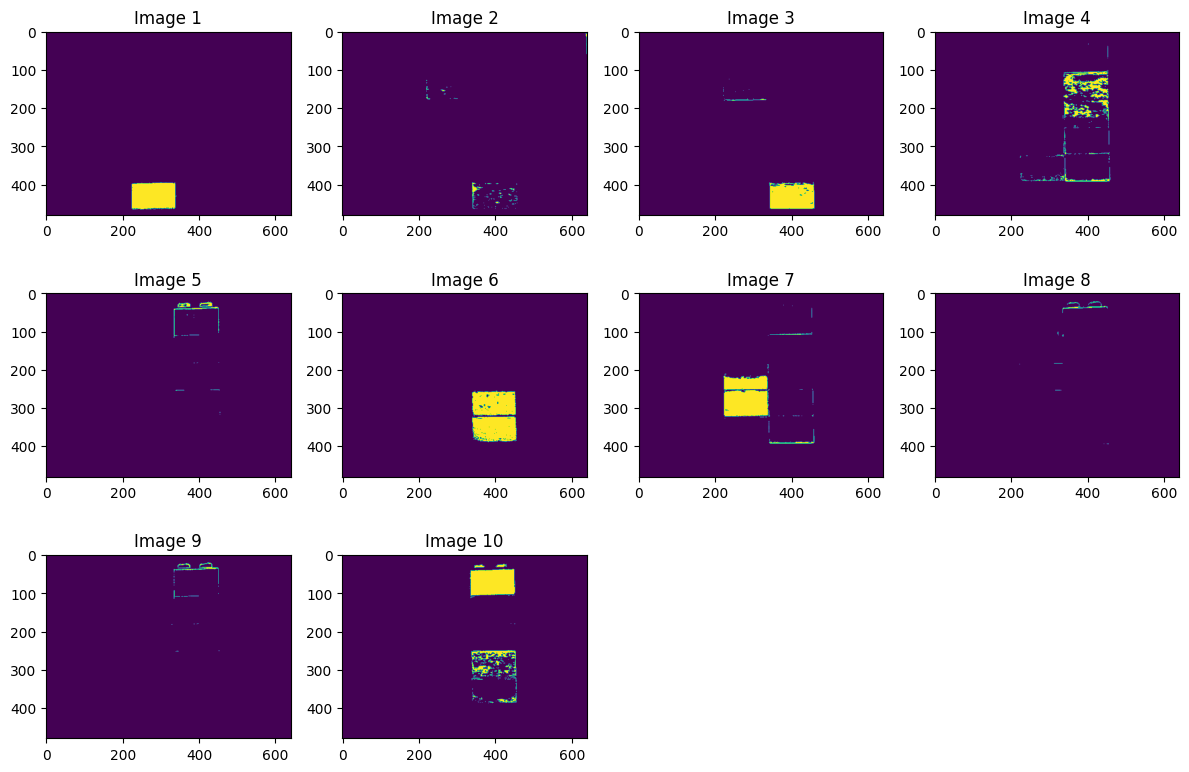

In [258]:
## Convert to hsv
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
images_masked = []
for key, value in colors.items():
    for space, value in value.items():
        if space == 'rgb':
            continue
        add = 30
        value_plus = tuple([x + add for x in value])
        value_minus = tuple([x - add for x in value])
        images_masked.append(cv2.inRange(hsv, value_minus, value_plus))

num_images = len(images_masked)
num_cols = 4  # Number of columns in the grid
num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows based on the number of images

fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 8))  # Adjust the figsize as needed

# Iterate through the images and plot them in the subplots
for i in range(num_images):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(images_masked[i])
    axs[row, col].set_title(f'Image {i+1}')  # Set title for each subplot

# Hide empty subplots
for i in range(num_images, num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].axis('off')

plt.tight_layout()
plt.show()

## One option

In [20]:
filepath = r'../test_images/1.jpg'
img = cv2.imread(filepath) # we use skimage because it load the .jpg wiht RGB colors
img.shape
plt.imshow(img)
imgRGB = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
_,imgThreshold = cv2.threshold(img,120,255,cv2.THRESH_BINARY_INV)

plt.figure()
plt.subplot(231)
plt.imshow(img)
plt.subplot(232)
plt.imshow(imgThreshold,cmap='gray')
kernel = np.ones((3,3),np.uint8)
imgDilate = cv2.morphologyEx(imgThreshold,cv2.MORPH_DILATE,kernel)
plt.subplot(233)
plt.imshow(imgDilate)
# computes distance from current pixel to nearest 0 pixel
distTrans = cv2.distanceTransform(imgDilate,cv2.DIST_L2,5)
plt.subplot(234)
plt.imshow(distTrans)
_,distThresh = cv2.threshold(distTrans,15,255,cv2.THRESH_BINARY)
plt.subplot(235)
plt.imshow(distThresh)
distThresh = np.uint8(distThresh)
_,labels = cv2.connectedComponents(distThresh)
plt.subplot(236)
plt.imshow(labels)
plt.figure() 
plt.subplot(121)
labels = np.int32(labels)
labels = cv2.watershed(imgRGB,labels)
plt.imshow(labels)
plt.subplot(122)
imgRGB[labels==-1] = [255,0,0]
plt.imshow(imgRGB)
plt.show()  

[ WARN:0@1135.692] global loadsave.cpp:248 findDecoder imread_('../test_images/1.jpg'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

## Superpixel

Felzenszwalb number of segments: 194
SLIC number of segments: 196
Quickshift number of segments: 695
Watershed number of segments: 256


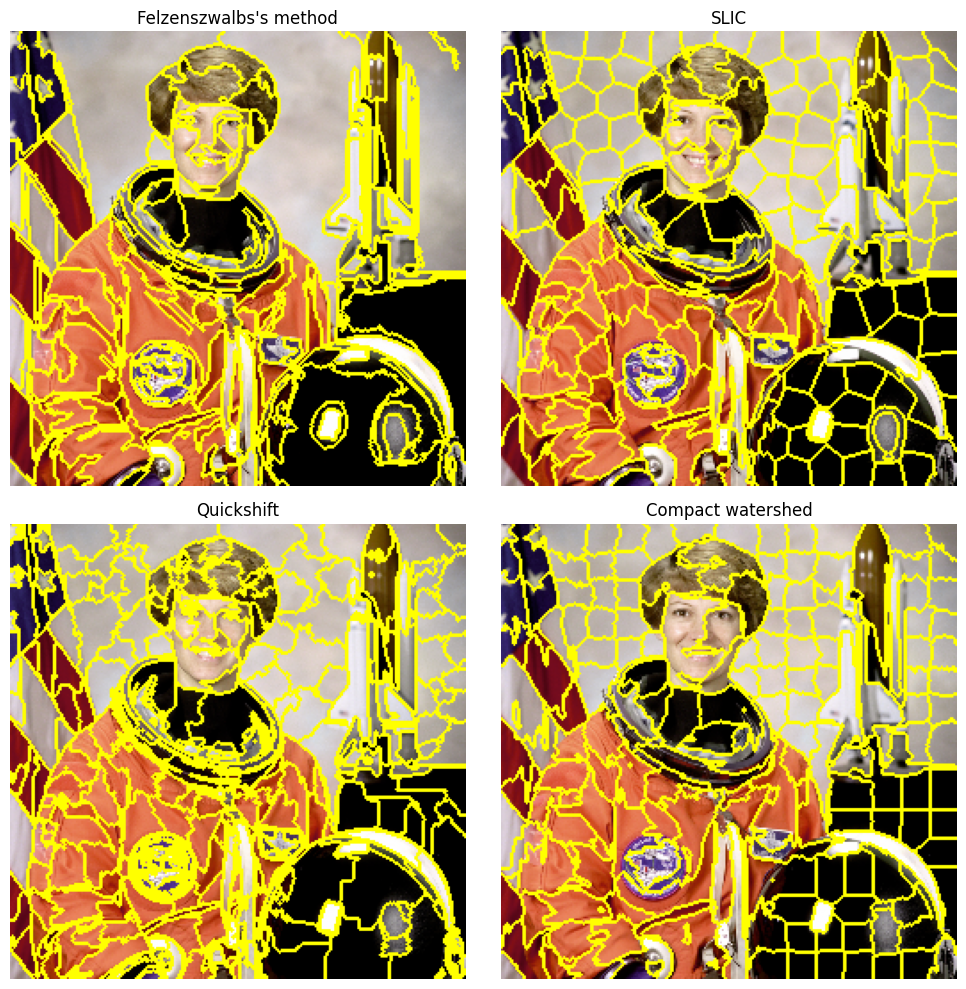

In [36]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.data import astronaut
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float

img = img_as_float(astronaut()[::2, ::2])

segments_fz = felzenszwalb(img, scale=100, sigma=0.5, min_size=50)
segments_slic = slic(img, n_segments=250, compactness=10, sigma=1, start_label=1)
segments_quick = quickshift(img, kernel_size=3, max_dist=6, ratio=0.5)
gradient = sobel(rgb2gray(img))
segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f'Felzenszwalb number of segments: {len(np.unique(segments_fz))}')
print(f'SLIC number of segments: {len(np.unique(segments_slic))}')
print(f'Quickshift number of segments: {len(np.unique(segments_quick))}')
print(f'Watershed number of segments: {len(np.unique(segments_watershed))}')

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

ax[0, 0].imshow(mark_boundaries(img, segments_fz))
ax[0, 0].set_title("Felzenszwalbs's method")
ax[0, 1].imshow(mark_boundaries(img, segments_slic))
ax[0, 1].set_title('SLIC')
ax[1, 0].imshow(mark_boundaries(img, segments_quick))
ax[1, 0].set_title('Quickshift')
ax[1, 1].imshow(mark_boundaries(img, segments_watershed))
ax[1, 1].set_title('Compact watershed')

for a in ax.ravel():
    a.set_axis_off()

plt.tight_layout()
plt.show()